In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
# Additional modules
# TODO: understand modules below
from tensorflow.contrib.data import shuffle_and_repeat
from tensorflow.contrib.data import parallel_interleave
from tensorflow.contrib.data import batch_and_drop_remainder

In [24]:
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction import analysis

In [16]:
import glob

In [134]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [155]:
import scipy.stats as scs

In [21]:
def load_tfdata(serialized_data,
                shape,
                batch_size=1,
                read_threads=4,
                shuffle_buffer_size=1000,
                prefetch=1,
                distribute=(1, 0)
               ):
    
    def parser(serialized_data):
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename":tf.FixedLenFeature([],tf.string),
            "coordinate":tf.FixedLenFeature([2],tf.int64),
        }
        decoded = tf.parse_single_example(serialized_data,features)
        patch   = tf.reshape(tf.decode_raw(decoded["patch"], tf.float32), decoded["shape"])
        
        # randomly crop mini-patches from data
        patch = tf.random_crop(patch, shape)
        
        return decoded["filename"], decoded["coordinate"], patch
 
    # TODO: understand this code
    dataset = (
    tf.data.Dataset.list_files(serialized_data, shuffle=True)
    .shard(*distribute)
    .apply(
        parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )

    # TODO: understand the code
    dataset = dataset.apply(batch_and_drop_remainder(batch_size)).prefetch(prefetch)
    return dataset

# Open-Closed cells

use m9-22 (ocean trained model)

## Get entire images in tfrecord

In [10]:
model_dir = "/home/tkurihana/clouds/output/m9-22_oceans/"
ENCODER_DEF=model_dir+'encoder.json'
ENCODER_WEIGHTS=model_dir+'encoder.h5'
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [12]:
encoder.input_shape

(None, 128, 128, 7)

In [3]:
OPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_open"
OPENS = OPENDATADIR+"/open.tfrecord"

In [22]:
load_data = load_tfdata(OPENS, encoder.input_shape[1:])

In [23]:
type(load_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [30]:
def _get_num_imgs(tfrecord):
    count=0
    for irecord in tf.python_io.tf_record_iterator(tfrecord):
        count += 1
    return count

In [31]:
oimgs = analysis._get_imgs(load_data, n=_get_num_imgs(OPENS))

In [32]:
oimgs.shape

(38, 128, 128, 7)

## Functionize

In [52]:
def get_datalist(datadir,iday=0, eday=31, keyward='MOD09GA_', cloud_type='open',
                 ):
    filelist = []
    for iday in range(iday, eday+1):
        if iday < 10:
            day = '0'+str(iday)
        else:
            day=str(iday)
        filelist.extend(glob.glob(datadir+'/2017JAN'+str(day)+keyward+cloud_type
                                    +'/'+cloud_type+'.tfrecord'))
        # TODO feature fix filename
        if cloud_type is 'close':
            filelist.extend(glob.glob(datadir+'/2017JAN'+str(day)+keyward+cloud_type
                                    +'/'+cloud_type+'d.tfrecord'))
    return filelist

In [42]:
# directory settings
label_datadir = '/home/tkurihana/scratch-midway2/clouds'

In [46]:
open_filelist = get_datalist(label_datadir, iday=1, eday=7, cloud_type='open')

In [47]:
open_filelist

['/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_open/open.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN02MOD09GA_open/open.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN03MOD09GA_open/open.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN04MOD09GA_open/open.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN05MOD09GA_open/open.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN06MOD09GA_open/open.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN07MOD09GA_open/open.tfrecord']

In [50]:
closed_filelist = get_datalist(label_datadir, iday=1, eday=7, cloud_type='close')

In [51]:
closed_filelist

['/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_close/closed.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN02MOD09GA_close/closed.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN03MOD09GA_close/closed.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN04MOD09GA_close/closed.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN05MOD09GA_close/closed.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN06MOD09GA_close/closed.tfrecord',
 '/home/tkurihana/scratch-midway2/clouds/2017JAN07MOD09GA_close/closed.tfrecord']

In [56]:
def _get_cloud_data(filelist, encoder):
    imgs_list = []
    for ifile in filelist:
        load_data = (load_tfdata(ifile, encoder.input_shape[1:]))
        imgs = analysis._get_imgs(load_data, n=_get_num_imgs(ifile))
        print(" ## Image shape ",imgs.shape, " ##" )
        imgs_list += [imgs]
    return np.asarray(imgs_list)

In [57]:
oimgs = _get_cloud_data(open_filelist, encoder)

 ## Image shape  (38, 128, 128, 7)  ##
 ## Image shape  (6, 128, 128, 7)  ##
 ## Image shape  (17, 128, 128, 7)  ##
 ## Image shape  (28, 128, 128, 7)  ##
 ## Image shape  (4, 128, 128, 7)  ##
 ## Image shape  (120, 128, 128, 7)  ##
 ## Image shape  (22, 128, 128, 7)  ##


In [58]:
cimgs = _get_cloud_data(closed_filelist, encoder)

 ## Image shape  (38, 128, 128, 7)  ##
 ## Image shape  (29, 128, 128, 7)  ##
 ## Image shape  (77, 128, 128, 7)  ##
 ## Image shape  (5, 128, 128, 7)  ##
 ## Image shape  (71, 128, 128, 7)  ##
 ## Image shape  (30, 128, 128, 7)  ##
 ## Image shape  (19, 128, 128, 7)  ##


## concatenation of images

In [60]:
oimg = np.concatenate(oimgs, axis=0)
cimg = np.concatenate(cimgs, axis=0)

In [61]:
oimg.shape

(235, 128, 128, 7)

In [138]:
def img_concatenation(imgs,skip=15):
    """ Gen Square like array image
        Because of np.asarray, some reduandant arrays are left out
    """
    col = []
    n = len(imgs)
    icount = 0
    for idx, i in enumerate(range(0,n, skip)):
        if n - (i+skip) > 0:
            col.append(np.concatenate([x for x in imgs[i:i+skip]], axis=1))
            icount += 1
    #if n - icount*skip > 0:
    #    print(n-icount*skip)
    #    j = n-icount*skip
    #    col.append(np.concatenate([x for x in imgs[j:]], axis=1))
    for idx, i in enumerate(col):
        print(i[idx].shape)
    return np.concatenate(col, axis=0)

In [129]:
int(np.sqrt(len(oimg)))

15

In [130]:
oimg_array = img_concatenation(oimg, skip=int(np.sqrt(len(oimg))))

(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)
(1920, 7)


In [131]:
oimg_array.shape

(1920, 1920, 7)

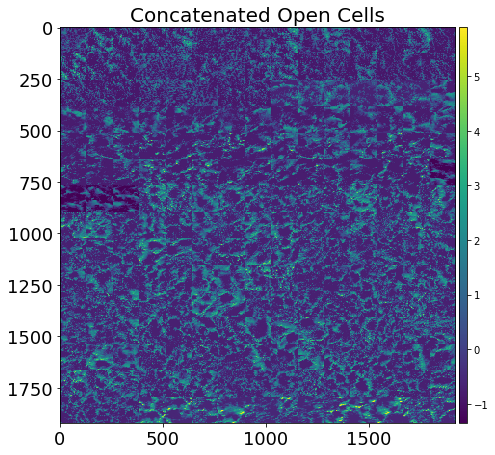

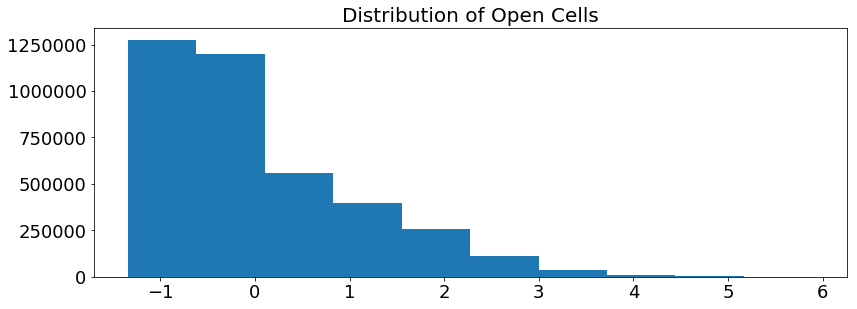

In [148]:
fig = plt.figure(figsize=(20,16))
# 2D Map
ax = plt.subplot(211)
im = plt.imshow(oimg_array[:,:,0])
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="2%", pad=0.05)
fig.add_axes(ax_cb)
fig.colorbar(im, cax=ax_cb)
ax.set_title("Concatenated Open Cells", fontsize=20)
ax.tick_params(labelsize=18)

# Histgram including left out arrays for plotting
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(212)
hist_array = oimg[:,:,:, 0].flatten()
plt.hist(hist_array)
ax.set_title("Distribution of Open Cells", fontsize=20)
ax.tick_params(labelsize=18)

fig.tight_layout()
plt.show()

In [142]:
cimg_array = img_concatenation(cimg, skip=int(np.sqrt(len(cimg))))

(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)
(2048, 7)


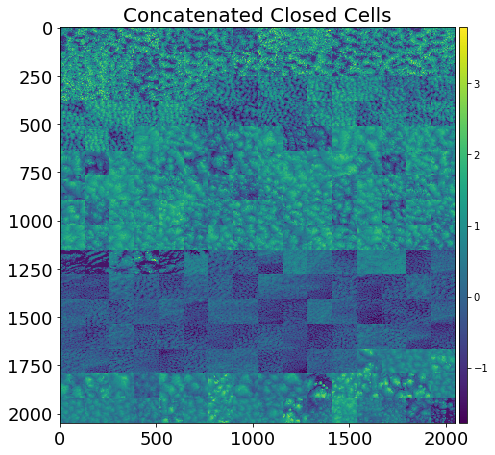

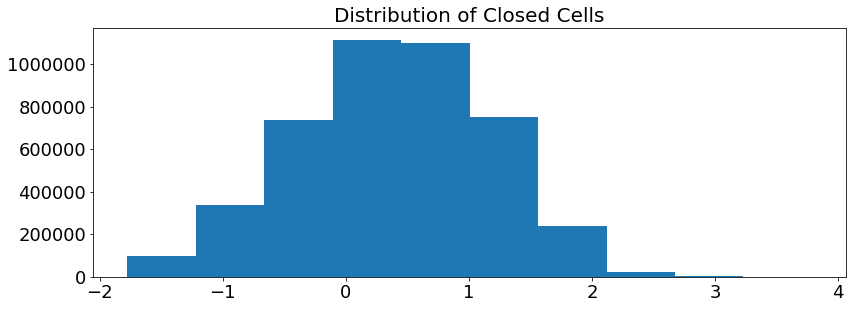

In [149]:
fig = plt.figure(figsize=(20,16))
# 2D Map
ax = plt.subplot(211)
im = plt.imshow(cimg_array[:,:,0])
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="2%", pad=0.05)
fig.add_axes(ax_cb)
fig.colorbar(im, cax=ax_cb)
ax.set_title("Concatenated Closed Cells", fontsize=20)
ax.tick_params(labelsize=18)

# Histgram including left out arrays for plotting
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(212)
hist_array = cimg[:,:,:, 0].flatten()
plt.hist(hist_array)
ax.set_title("Distribution of Closed Cells", fontsize=20)
ax.tick_params(labelsize=18)

fig.tight_layout()
plt.show()

## Cloud ratio

In [154]:
# open
tmp_open = oimg[:,:,:,0].flatten()
open_cloud_ratio = len(np.argwhere( tmp_open > 0))/len(tmp_open)*100
print(" Cloud Ration in open cell %f percent" %open_cloud_ratio)

# closed
tmp_closed = cimg[:,:,:,0].flatten()
closed_cloud_ratio = len(np.argwhere( tmp_closed > 0))/len(tmp_closed)*100
print(" Cloud Ration in closed cell %f precent" %closed_cloud_ratio)

 Cloud Ration in open cell 38.461680 percent
 Cloud Ration in closed cell 68.796264 precent


In [158]:
def _cloud_stats(img):
    img_vals = []
    for i in img:
        tmp = i[:,:,0].flatten()
        img_vals += [len(np.argwhere( tmp > 0))/len(tmp)]
    mean = np.mean(img_vals)*100
    stdv = np.std(img_vals)
    skew = scs.skew(img_vals)
    kurt = scs.kurtosis(img_vals)
    for jdx, j in enumerate([mean, stdv, skew, kurt]):
        print(" %d moment  == %f " %(jdx, j))

In [159]:
#OPEN
_cloud_stats(oimg)

 0 moment  == 38.461680 
 1 moment  == 0.114590 
 2 moment  == 0.310195 
 3 moment  == -0.087716 


In [160]:
#CLOSED
_cloud_stats(cimg)

 0 moment  == 68.796264 
 1 moment  == 0.304840 
 2 moment  == -0.838000 
 3 moment  == -0.589697 


## save array as npy file

In [161]:
#open
savedir="/home/tkurihana/scratch-midway2/clouds"
np.save(savedir+"/open_array", oimg)

In [162]:
#open
savedir="/home/tkurihana/scratch-midway2/clouds"
np.save(savedir+"/closed_array", cimg)